# Sentiment Analysis Using Machine Learning

This project focuses on building a simple sentiment analysis system using traditional machine learning algorithms — **Support Vector Machine (SVM)** and **Random Forest**.

The idea is to train a model that can understand the emotional tone of a short text, such as a sentence or phrase (e.g. "im contemplating and feeling skeptical" → fear). We’ll use a labeled dataset containing sentences and their corresponding emotions to train and test our models.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import spacy

## Load and Explore the Dataset

We’ll be working with a labeled dataset of text samples, where each row contains a short sentence and the corresponding emotion (like *happy*, *anger*, *sadness*, etc.).  
This dataset was downloaded from Kaggle — you can find it [here](<https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text/data>).

Let’s start by loading the data into a pandas DataFrame and taking a quick look at its shape and contents.


In [15]:
df = pd.read_csv("../data/Emotion_final.csv")

print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

print("Here are the first 5 rows of the dataset:")
df.head(5)

Dataset contains 21459 rows and 2 columns.

Here are the first 5 rows of the dataset:


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [16]:
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [17]:
print("Label distribution:")
df['Emotion'].value_counts()

Label distribution:


Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: count, dtype: int64

In [18]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Text       0
Emotion    0
dtype: int64


## Text Preprocessing

Before we can feed the text data into a machine learning model, we need to clean and normalize it.

In this step, we’ll:
- Tokenize each sentence into individual words
- Remove stopwords (like "and", "is", "the", etc.)
- Remove punctuation
- Lemmatize words (convert them to their base form, e.g. "running" → "run")

We're using **spaCy**, a powerful NLP library, to handle this processing.  
We’ll first test the pipeline on a single example to see how it works, then apply it to the entire dataset.


In [25]:
nlp = spacy.load('en_core_web_sm')

In [26]:
sample_text = df['Text'].iloc[5]
print("Original text:")
print(sample_text)

Original text:
ive been feeling a little burdened lately wasnt sure why that was


In [27]:
print("Tokenized:")
print([token.text for token in doc])

Tokenized:
['i', 've', 'been', 'feeling', 'a', 'little', 'burdened', 'lately', 'was', 'nt', 'sure', 'why', 'that', 'was']


In [29]:
print("Lemmatized tokens:")
print([token.lemma_ for token in doc])

Lemmatized tokens:
['I', 've', 'be', 'feel', 'a', 'little', 'burden', 'lately', 'be', 'not', 'sure', 'why', 'that', 'be']


In [30]:
print("Stopwords and punctuation:")
print([token.text for token in doc if token.is_stop or token.is_punct])

Stopwords and punctuation:
['i', 'been', 'a', 'was', 'why', 'that', 'was']


In [31]:
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [33]:
print("Original text:")
print(sample_text)
print("Preprocessed version:")
print(preprocess(sample_text))

Original text:
ive been feeling a little burdened lately wasnt sure why that was
Preprocessed version:
ve feel little burden lately not sure


In [34]:
df['preprocessed_text'] = df['Text'].apply(preprocess)
df.head()

,Text,Emotion,preprocessed_text
0,i didnt feel humiliated,sadness,not feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damned hopeful care awake
2,im grabbing a minute to post i feel greedy wrong,anger,m grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,feel nostalgic fireplace know property
4,i am feeling grouchy,anger,feel grouchy


## Encoding the Labels

Machine learning models can't work directly with text labels — they need numerical input.

Here, we use `LabelEncoder` from scikit-learn to convert the emotion names into integers.  
Each unique emotion is assigned a different number, which will be used as the target during training.


In [35]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df['Emotion_label']=label.fit_transform(df['Emotion'])
df.head(10)

,Text,Emotion,preprocessed_text,Emotion_label
0,i didnt feel humiliated,sadness,not feel humiliated,4
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damned hopeful care awake,4
2,im grabbing a minute to post i feel greedy wrong,anger,m grab minute post feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,love,feel nostalgic fireplace know property,3
4,i am feeling grouchy,anger,feel grouchy,0
5,ive been feeling a little burdened lately wasn...,sadness,ve feel little burden lately not sure,4
6,ive been taking or milligrams or times recomme...,surprise,ve take milligram time recommend ve fall aslee...,5
7,i feel as confused about life as a teenager or...,fear,feel confused life teenager jade year old man,1
8,i have been with petronas for years i feel tha...,happy,petrona year feel petronas perform huge profit,2
9,i feel romantic too,love,feel romantic,3


## Splitting the Dataset

To evaluate how well our model generalizes to unseen data, we split the dataset into a **training set** and a **test set**.

We’ll use 75% of the data for training, and 25% for testing.  
The `stratify` argument ensures that each emotion is equally represented in both sets, maintaining a balanced distribution.


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], df['Emotion_label'],
                                                    test_size=0.25, random_state=42, stratify=df['Emotion_label'])

In [37]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (16094,)
Shape of X_test:  (5365,)


In [24]:
# Tworzenie wektorów TF-IDF z tekstu
v = TfidfVectorizer()

X_train_cv = v.fit_transform(X_train)
X_test_cv = v.transform(X_test)

In [25]:
print("Shape of X_train_cv: ", X_train_cv.shape)
print("Shape of X_test_cv: ", X_test_cv.shape)
X_test_cv

Shape of X_train_cv:  (16094, 13029)
Shape of X_test_cv:  (5365, 13029)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 38584 stored elements and shape (5365, 13029)>

In [26]:
# Trenowanie modelu RF
RFC_model = RandomForestClassifier()

RFC_model.fit(X_train_cv, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
# Przewidywanie etykiet na zbiorze testowy
y_pred = RFC_model.predict(X_test_cv)

In [28]:
# Wypisanie dokładności modelu
print(accuracy_score(y_test, y_pred))

0.8620689655172413


In [29]:
# Wypisanie raportu klasyfikacji
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       748
           1       0.86      0.84      0.85       663
           2       0.85      0.92      0.88      1758
           3       0.85      0.67      0.75       410
           4       0.90      0.88      0.89      1566
           5       0.80      0.71      0.75       220

    accuracy                           0.86      5365
   macro avg       0.85      0.81      0.83      5365
weighted avg       0.86      0.86      0.86      5365



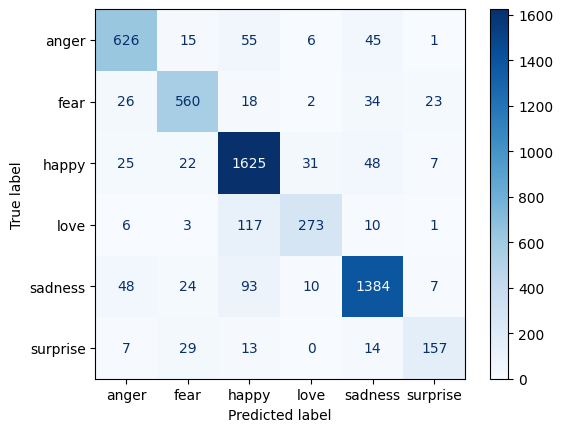

In [30]:
# Tworzenie i wyświetlanie macierzy błędów
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculating the table of errors
cm = confusion_matrix(y_test, y_pred)

# Displaying the table of errors
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [31]:
# Trenowanie modelu SVM
from sklearn.svm import SVC
model_svm = SVC(kernel = 'linear', random_state = 0)
model_svm.fit(X_train_cv, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [32]:
# Przewidywanie etykiet na zbiorze testowym za pomocą SVM
y_pred=model_svm.predict(X_test_cv)

In [33]:
# Wypisanie dokładności modelu SVM
print(accuracy_score(y_test, y_pred))

0.8631873252562908


In [34]:
# Wypisanie raportu klasyfikacji SVM
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       748
           1       0.82      0.84      0.83       663
           2       0.87      0.92      0.89      1758
           3       0.79      0.69      0.74       410
           4       0.89      0.90      0.90      1566
           5       0.80      0.69      0.74       220

    accuracy                           0.86      5365
   macro avg       0.84      0.81      0.82      5365
weighted avg       0.86      0.86      0.86      5365



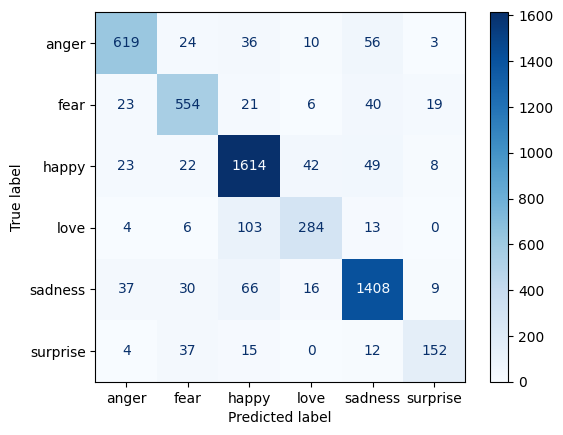

In [35]:
# Tworzenie i wyświetlanie macierzy błędów dla SVM
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()